In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import itertools

In [41]:
# グラフの設定
fontsize_title = 25
fontsize_label = 20
max_xlin = 52

# サンプリング周波数
fs_acc = 390
fs_gyro = 390
fs_pressure = 20

In [42]:
# CSVファイルを読み込む
path = "./logs/stairs/"
acc_file_name = f"{path}Accelerometer.csv"
gyro_file_name = f"{path}Gyroscope.csv"
pressure_file_name = f"{path}Pressure.csv"

df_acc = pd.read_csv(
    acc_file_name,
    header=0,
    names=("time", "x", "y", "z")
)
df_gyro = pd.read_csv(
    gyro_file_name,
    header=0,
    names=("time", "x", "y", "z")
)
df_pressure = pd.read_csv(
    pressure_file_name,
    header=0,
    names=("time", "pressure")
)

df_acc["time"] = df_acc["time"]
df_gyro["time"] = df_gyro["time"]


<Figure size 640x480 with 0 Axes>

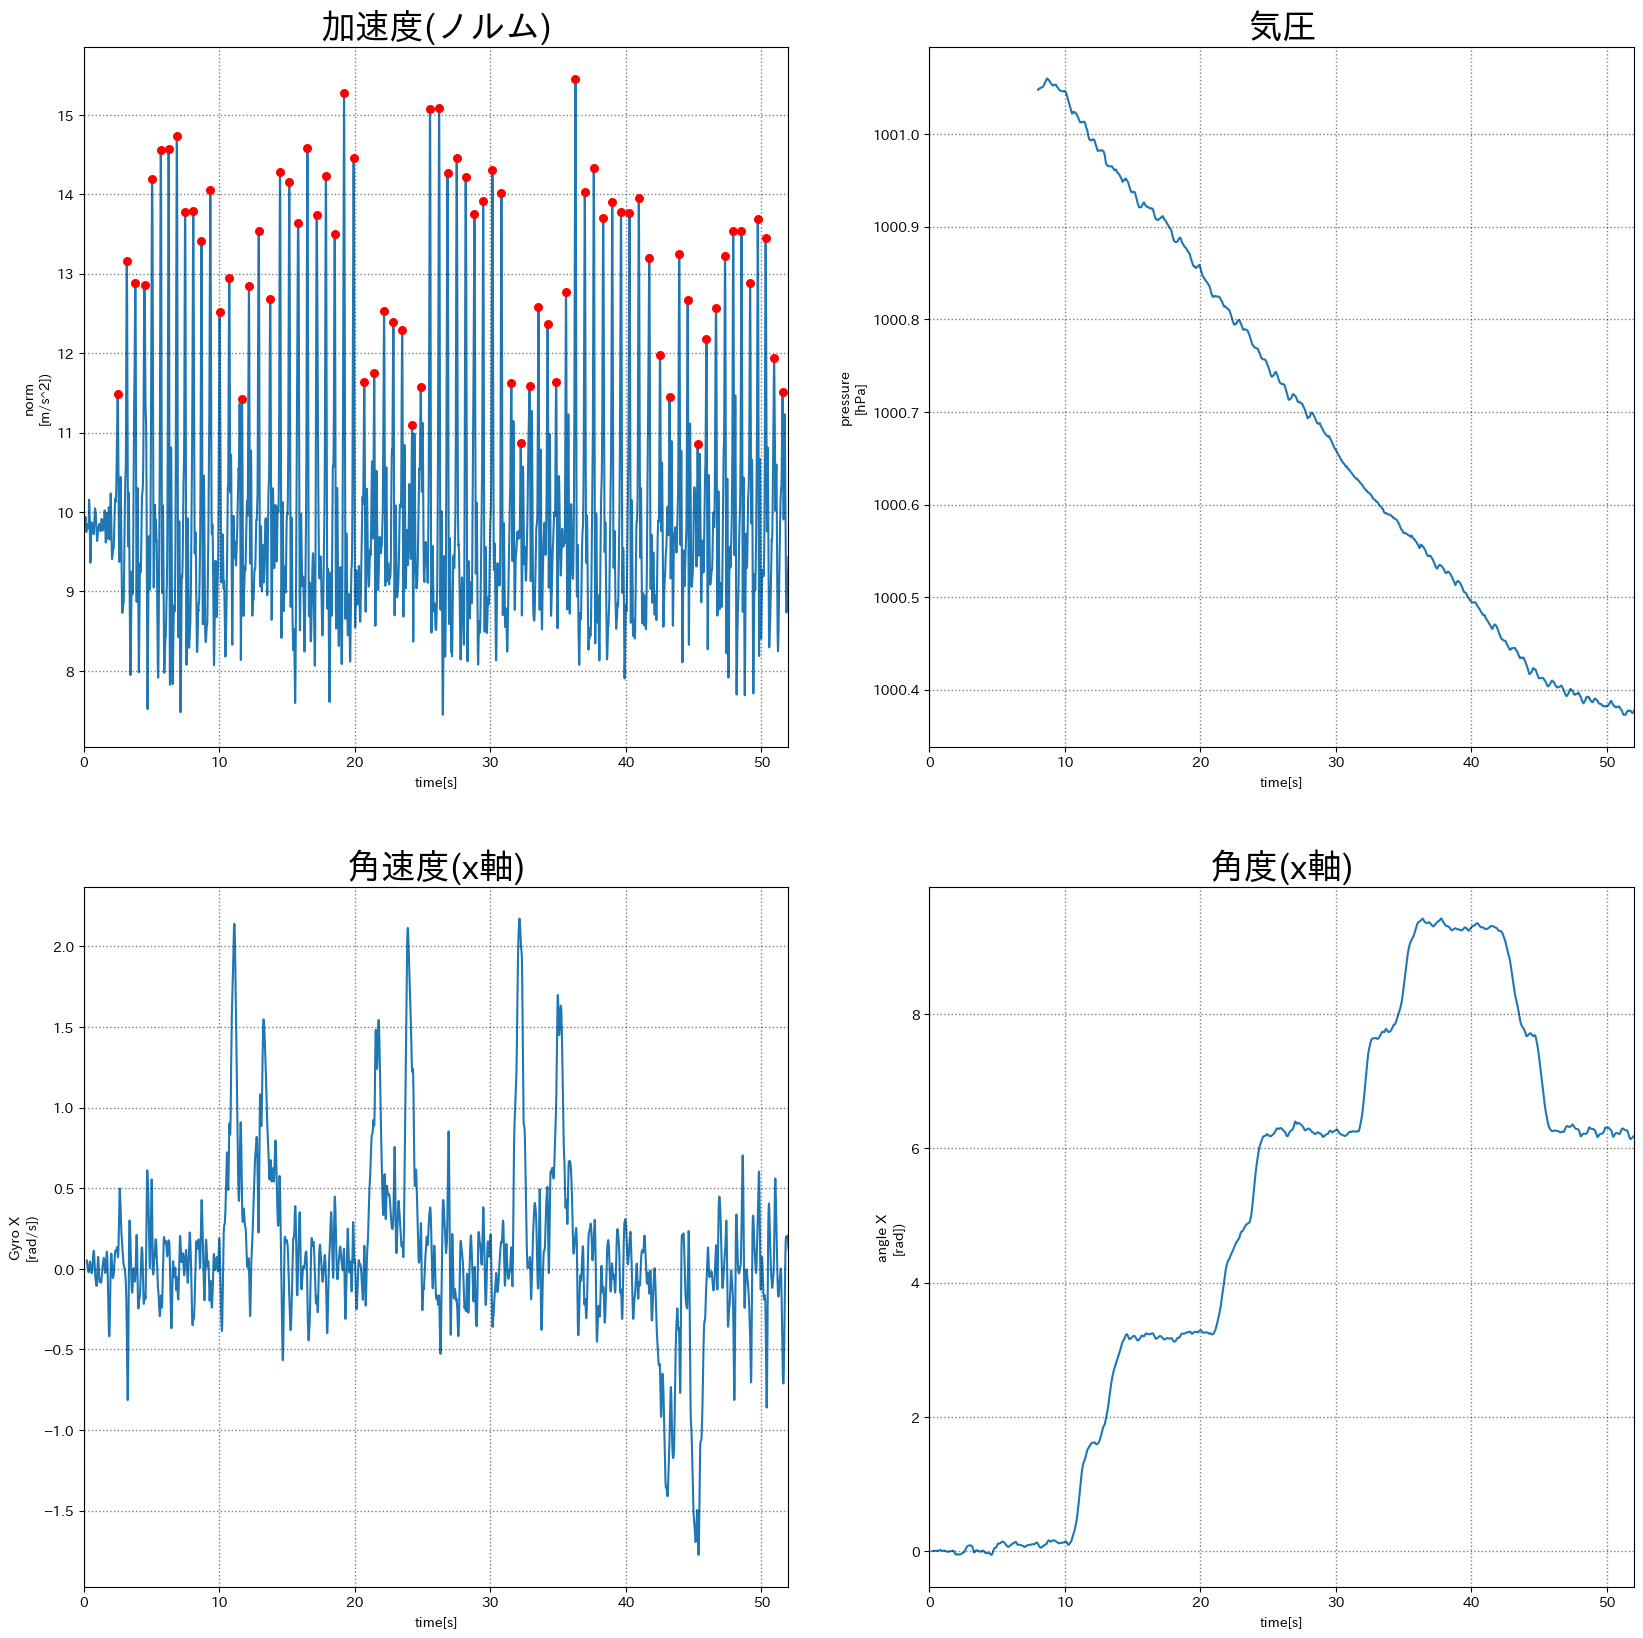

In [43]:
# ノルムを求める
df_acc['norm'] = np.linalg.norm(df_acc[['x', 'y', 'z']], axis=1)

# 角度を求める
df_gyro['angle'] = np.cumsum(df_gyro['x']) / fs_gyro

# window=10の移動平均
window = 40
df_acc['low_norm'] = df_acc['norm'].rolling(window=window).mean()
df_pressure['low'] = df_pressure['pressure'].rolling(window=160).mean()
df_gyro['low_x'] = df_gyro['x'].rolling(window=window).mean()
df_gyro['low_angle'] = df_gyro['angle'].rolling(window=window).mean()

# グラフを描画する
plt.subplots_adjust(hspace=0.3)
fig = plt.figure(figsize=(20, 20))

## 加速度
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(df_acc['time'], df_acc['low_norm'], zorder=1)
ax1.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
ax1.set_title('加速度(ノルム)', fontdict={'size': fontsize_title})
ax1.set_xlim(0, max_xlin)
plt.xlabel('time[s]')
plt.ylabel('norm\n[m/s^2])')

### ピークを描画
peek, _ = signal.find_peaks(df_acc['low_norm'], distance=120, height=10.5)
ax1.scatter(df_acc['time'][peek], df_acc['low_norm'][peek], s=30, color='red', zorder=2)

## 気圧
ax4 = fig.add_subplot(2, 2, 2)
ax4.plot(df_pressure['time'], df_pressure['low'], zorder=1)
ax4.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
ax4.set_title('気圧', fontdict={'size': fontsize_title})
ax4.set_xlim(0, max_xlin)
plt.xlabel('time[s]')
plt.ylabel('pressure\n[hPa]')

## 角速度
ax2 = fig.add_subplot(2, 2, 3)
ax2.plot(df_gyro['time'], df_gyro['low_x'], zorder=1)
ax2.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
ax2.set_title('角速度(x軸)', fontdict={'size': fontsize_title})
ax2.set_xlim(0, max_xlin)
plt.xlabel('time[s]')
plt.ylabel('Gyro X\n[rad/s])')

## 角度
ax3 = fig.add_subplot(2, 2, 4)
ax3.plot(df_gyro['time'], df_gyro['low_angle'], zorder=1)
ax3.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
ax3.set_title('角度(x軸)', fontdict={'size': fontsize_title})
ax3.set_xlim(0, max_xlin)
plt.xlabel('time[s]')
plt.ylabel('angle X\n[rad])')


plt.show()


(-0.5, 6.0)

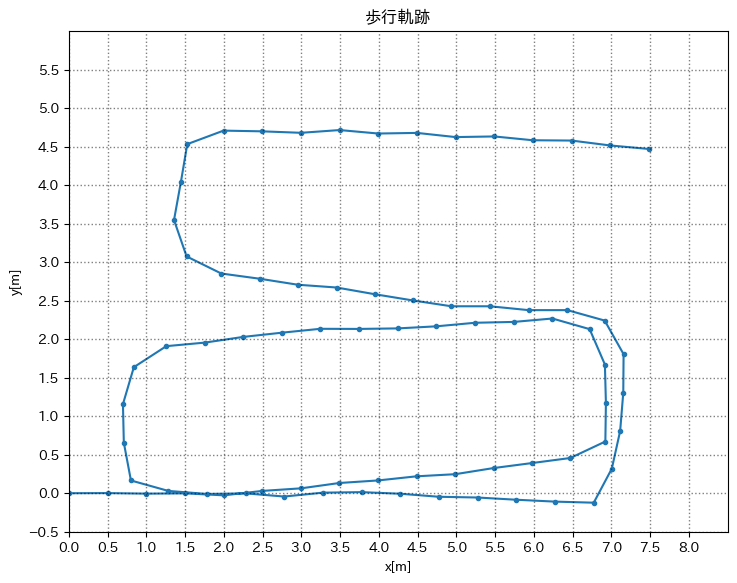

In [44]:
# 軌跡を描く
point = [[0, 0]]
for p in peek:
    x = 0.5 * np.cos(df_gyro['low_angle'][p]) + point[-1][0]
    y = 0.5 * np.sin(df_gyro['low_angle'][p]) + point[-1][1]

    point.append([x, y])

point = pd.DataFrame(data=point, columns=['x', 'y'])

point['x'] = point['x'] - point['x'][0]
point['y'] = point['y'] - point['y'][0]

# グラフを描画する
size = ((0, 8.5), (-0.5, 6))
plt.figure(figsize=(size[0][1]-size[0][0], size[1][1]-size[1][0]))

plt.plot(point['x'], point['y'], '.-', label='推定', zorder=1)

plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5, zorder=2)
plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.xticks(np.arange(size[0][0], size[0][1], 0.5))
plt.yticks(np.arange(size[1][0], size[1][1], 0.5))
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])


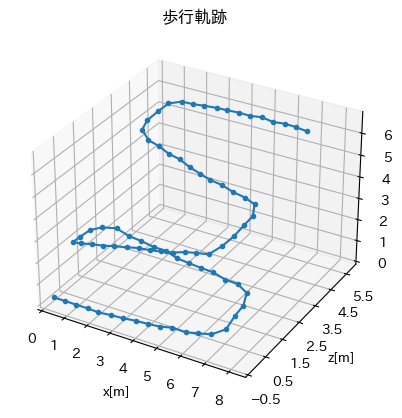

In [46]:
# 軌跡を描く
point = [[0, 0, 0, 0]]
for p in peek:
    x = 0.5 * np.cos(df_gyro['low_angle'][p]) + point[-1][1]
    y = 0.5 * np.sin(df_gyro['low_angle'][p]) + point[-1][2]
    z = df_pressure['low'][int(p * 0.0487804878)]
    z = df_pressure['low'].max() if np.isnan(z) else z
    t = df_gyro['time'][p]

    point.append([t, round(x, 10), round(y, 10), round(z, 10)])

point = pd.DataFrame(data=point, columns=['time', 'x', 'y', 'z'])

point['z'] = (point['z'] - point['z'][1]) * -10
point['z'][0] = point['z'][1]

# グラフを描画する
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(point['x'], point['y'], point['z'], '.-', zorder=1)
# ax.view_init(elev=0, azim=90)

plt.title('歩行軌跡')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.ylabel('z[m]')
plt.xticks(np.arange(size[0][0], size[0][1], 1))
plt.yticks(np.arange(size[1][0], size[1][1], 1))
plt.xlim(size[0][0], size[0][1])
plt.ylim(size[1][0], size[1][1])

plt.show()

# 軌跡をcsvに保存
point.to_csv('./logs/point.csv', index=False)
